In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
import simweights
import pickle
import os, sys
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import pandas as pd
import tables
import h5py
import math
from scipy.stats import mstats
import matplotlib as mpl
import matplotlib.font_manager as font_manager


In [81]:
sys.path.append('/data/user/tvaneede/GlobalFit/reco_processing/notebooks/weighting')

from datasets import datasets

In [82]:
filetype = "NuTau_E2" # NuTau_E2

In [85]:
# astro
per_flavor_norm = 2.12
gamma_astro = 2.87
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year

def AstroFluxModel(pdgid, energy, cos_zen):
    flux = 0.5*(per_flavor_norm*1e-18)*(energy/1e5)**-gamma_astro
    return flux

In [86]:
def get_var_weights( dataset_name, filetype = "NuTau_E2" ):
    file     = datasets[dataset_name][filetype]["file_path"]
    nfiles   = datasets[dataset_name][filetype]["nfiles"]
    hdf      = pd.HDFStore(file,'r')
    weighter = simweights.NuGenWeighter(hdf, nfiles=nfiles)
    weights  = weighter.get_weights( AstroFluxModel )
    return hdf, weights, weighter

In [87]:
# ftp l3 files
hdf_ftp_l3casc, weights_ftp_l3casc, weighter_ftp_l3casc = get_var_weights( "ftp_l3casc" )

In [88]:
# spice l3 files
hdf_spice_l3casc, weights_spice_l3casc, weighter_spice_l3casc = get_var_weights( "spice_l3casc" )

How do ftp and spice compare? They match very well.

event rate
weights_spice_l3casc 1271.5747991890207
weights_ftp_l3casc 1250.8006383426268


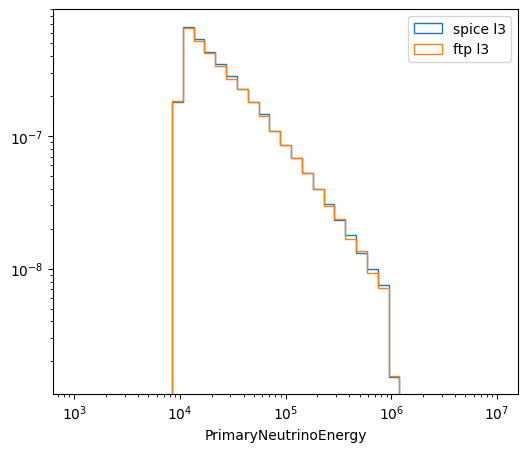

In [92]:
fig, ax = plt.subplots(1, 1,figsize =(6,5))

# PrimaryNeutrinoEnergy
variable = "PrimaryNeutrinoEnergy" # PrimaryNeutrinoEnergy PrimaryNeutrinoType
bins = np.geomspace( 1e3, 1e7, 40 )

ax.hist(hdf_spice_l3casc["I3MCWeightDict"][variable].values, weights=weights_spice_l3casc, bins=bins, histtype="step", label=f"spice l3")
ax.hist(hdf_ftp_l3casc["I3MCWeightDict"][variable].values, weights=weights_ftp_l3casc, bins=bins, histtype="step", label=f"ftp l3")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(variable)
ax.legend()

print("event rate")
print("weights_spice_l3casc", sum(weights_spice_l3casc)*livetime_s)
print("weights_ftp_l3casc", sum(weights_ftp_l3casc)*livetime_s)


Now let's see which events Neha reconstructed, and see if I can select them manually from the l3 files. This seems to work fine.

In [17]:
hdf_spice_tau_reco, weights_spice_tau_reco, weighter_spice_tau_reco = get_var_weights( "spice_tau_reco" )

0
event rate
weights_spice_l3casc 1271.5747991890207
weights_spice_tau_reco 32.940765062367596
weights_cut 32.25342366747626


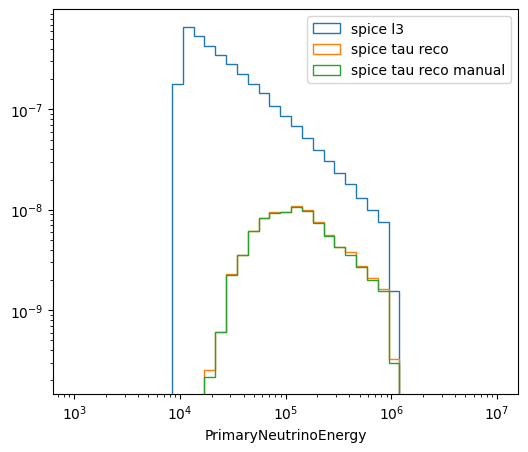

In [ ]:
fig, ax = plt.subplots(1, 1,figsize =(6,5))

# PrimaryNeutrinoEnergy
variable = "PrimaryNeutrinoEnergy" # PrimaryNeutrinoEnergy PrimaryNeutrinoType
bins = np.geomspace( 1e3, 1e7, 40 )

ax.hist(hdf_spice_l3casc["I3MCWeightDict"][variable].values, weights=weights_spice_l3casc, bins=bins, histtype="step", label=f"spice l3")
ax.hist(hdf_spice_tau_reco["I3MCWeightDict"][variable].values, weights=weights_spice_tau_reco, bins=bins, histtype="step", label=f"spice tau reco")

# manual HESE_CausalQTot and HESE_VHESelfVeto on l3 files
HESE_CausalQTot = hdf_spice_l3casc["HESE_CausalQTot"].value.values
HESE_VHESelfVeto = hdf_spice_l3casc["HESE_VHESelfVeto"].value.values
PrimaryNeutrinoEnergy = hdf_spice_l3casc["I3MCWeightDict"][variable].values
weights = weights_spice_l3casc
mask = (HESE_VHESelfVeto == False) & (HESE_CausalQTot > 6000)
weights_cut = weights[mask]
PrimaryNeutrinoEnergy_cut = PrimaryNeutrinoEnergy[mask]

ax.hist(PrimaryNeutrinoEnergy_cut, weights=weights_cut, bins=bins, histtype="step", label=f"spice tau reco manual")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(variable)
ax.legend()

print(sum(HESE_VHESelfVeto))

print("event rate")
print("weights_spice_l3casc", sum(weights_spice_l3casc)*livetime_s)
print("weights_spice_tau_reco", sum(weights_spice_tau_reco)*livetime_s)
print("weights_cut", sum(weights_cut)*livetime_s)

Now lets see if I can select my v1 files from the l3 files for ftp. It was a loose hese selection, with only 1500 PE.

In [34]:
hdf_ftp_v1_wpid, weights_ftp_v1_wpid, weighter_ftp_v1_wpid = get_var_weights( "v1_wpid" )

VHESelfVeto has only 0s 0
HESE_CausalQTot minimum value is 0.0
HESE_CausalQTot minimum value without 0 is 1500.0750036686659
event rate
weights_ftp_l3casc 1250.8006383426268
weights_ftp_v1_wpid 92.15025642207385
weights_cut 32.41837213952271


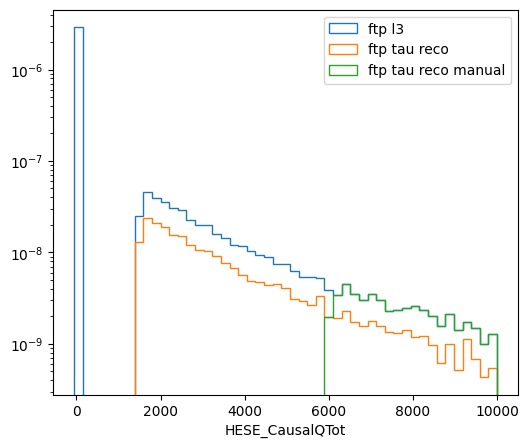

In [ ]:
fig, ax = plt.subplots(1, 1,figsize =(6,5))

# HESE_CausalQTot
variable = "HESE_CausalQTot"
bins = np.linspace( -50, 1e4, 50 )

ax.hist(hdf_ftp_l3casc[variable].value.values, weights=weights_ftp_l3casc, bins=bins, histtype="step", label=f"ftp l3")
ax.hist(hdf_ftp_v1_wpid[variable].value.values, weights=weights_ftp_v1_wpid, bins=bins, histtype="step", label=f"ftp tau reco")

# manual HESE_VHESelfVeto
HESE_VHESelfVeto = hdf_ftp_l3casc["HESE_VHESelfVeto"].value.values
HESE_CausalQTot = hdf_ftp_l3casc[variable].value.values
weights = weights_ftp_l3casc
mask = (HESE_VHESelfVeto == False) & (HESE_CausalQTot > 6000)
weights_cut = weights[mask]
HESE_CausalQTot_cut = HESE_CausalQTot[mask]

ax.hist(HESE_CausalQTot_cut, weights=weights_cut, bins=bins, histtype="step", label=f"ftp tau reco manual")

ax.set_yscale("log")
ax.set_xlabel(variable)
ax.legend()

print("VHESelfVeto has only 0s", sum(HESE_VHESelfVeto) )
print("HESE_CausalQTot minimum value is", min(HESE_CausalQTot) )
print("HESE_CausalQTot minimum value without 0 is", min(HESE_CausalQTot[HESE_CausalQTot != 0]) )

print("event rate")
print("weights_ftp_l3casc", sum(weights_ftp_l3casc)*livetime_s)
print("weights_ftp_v1_wpid", sum(weights_ftp_v1_wpid)*livetime_s)
print("weights_cut", sum(weights_cut)*livetime_s)


So lets see if I can match ftp and spice. It works! Why was I running into problems before?

0
event rate
weights_spice_l3casc 1271.5747991890207
weights_ftp_l3casc 1250.8006383426268
weights_spice_tau_reco 32.940765062367596
weights_cut 32.41837213952271


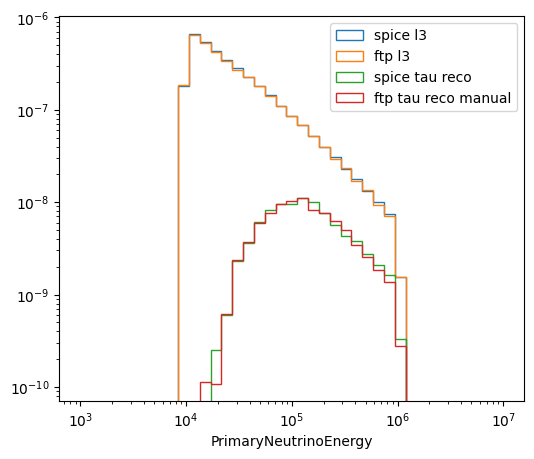

In [103]:
fig, ax = plt.subplots(1, 1,figsize =(6,5))

# PrimaryNeutrinoEnergy
variable = "PrimaryNeutrinoEnergy" # PrimaryNeutrinoEnergy PrimaryNeutrinoType
bins = np.geomspace( 1e3, 1e7, 40 )

ax.hist(hdf_spice_l3casc["I3MCWeightDict"][variable].values, weights=weights_spice_l3casc, bins=bins, histtype="step", label=f"spice l3")
ax.hist(hdf_ftp_l3casc["I3MCWeightDict"][variable].values, weights=weights_ftp_l3casc, bins=bins, histtype="step", label=f"ftp l3")

# tau reco
ax.hist(hdf_spice_tau_reco["I3MCWeightDict"][variable].values, weights=weights_spice_tau_reco, bins=bins, histtype="step", label=f"spice tau reco")

# manual casualQtot and
HESE_CausalQTot = hdf_ftp_l3casc["HESE_CausalQTot"].value.values
HESE_VHESelfVeto = hdf_ftp_l3casc["HESE_VHESelfVeto"].value.values
PrimaryNeutrinoEnergy = hdf_ftp_l3casc["I3MCWeightDict"][variable].values
weights = weights_ftp_l3casc
mask = (HESE_VHESelfVeto == False) & (HESE_CausalQTot > 6000)
weights_cut = weights[mask]
PrimaryNeutrinoEnergy_cut = PrimaryNeutrinoEnergy[mask]

ax.hist(PrimaryNeutrinoEnergy_cut, weights=weights_cut, bins=bins, histtype="step", label=f"ftp tau reco manual")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(variable)
ax.legend()

print(sum(HESE_VHESelfVeto))

print("event rate")
print("weights_spice_l3casc", sum(weights_spice_l3casc)*livetime_s)
print("weights_ftp_l3casc", sum(weights_ftp_l3casc)*livetime_s)
print("weights_spice_tau_reco", sum(weights_spice_tau_reco)*livetime_s)
print("weights_cut", sum(weights_cut)*livetime_s)

lets get neha files again

In [70]:
hdf_neha_track, weights_neha_track, weighter_neha_track = get_var_weights( "neha_track_AllHESE", "NuTau_E2_2" )
hdf_neha_cascade, weights_neha_cascade, weighter_neha_cascade = get_var_weights( "neha_cascade_AllHESE", "NuTau_E2_2" )
hdf_neha_doublecascade, weights_neha_doublecascade, weighter_neha_doublecascade = get_var_weights( "neha_doublecascade_AllHESE", "NuTau_E2_2" )

In [71]:
# combine
variable = "PrimaryNeutrinoEnergy" # PrimaryNeutrinoEnergy PrimaryNeutrinoType
energy_combined_spiceall = np.concatenate((hdf_neha_track["I3MCWeightDict"][variable].values, 
                                           hdf_neha_cascade["I3MCWeightDict"][variable].values, 
                                           hdf_neha_doublecascade["I3MCWeightDict"][variable].values))
weights_combined_spiceall = np.concatenate(( weights_neha_track, weights_neha_cascade, weights_neha_doublecascade))

event rate
weights_spice_l3casc 1271.5747991890207
weights_ftp_l3casc 1250.8006383426268
weights_spice_tau_reco 32.940765062367596
weights_cut 32.41837213952271
weights_combined_spiceall 33.55965621318159


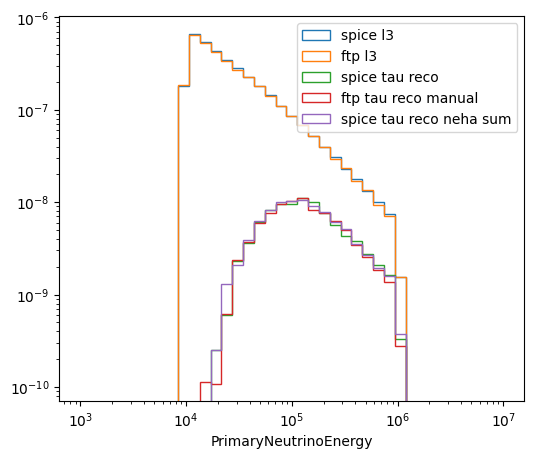

In [94]:
fig, ax = plt.subplots(1, 1,figsize =(6,5))

# PrimaryNeutrinoEnergy
variable = "PrimaryNeutrinoEnergy" # PrimaryNeutrinoEnergy PrimaryNeutrinoType
bins = np.geomspace( 1e3, 1e7, 40 )

ax.hist(hdf_spice_l3casc["I3MCWeightDict"][variable].values, weights=weights_spice_l3casc, bins=bins, histtype="step", label=f"spice l3")
ax.hist(hdf_ftp_l3casc["I3MCWeightDict"][variable].values, weights=weights_ftp_l3casc, bins=bins, histtype="step", label=f"ftp l3")

# tau reco
ax.hist(hdf_spice_tau_reco["I3MCWeightDict"][variable].values, weights=weights_spice_tau_reco, bins=bins, histtype="step", label=f"spice tau reco")

# manual casualQtot and
HESE_CausalQTot = hdf_ftp_l3casc["HESE_CausalQTot"].value.values
HESE_VHESelfVeto = hdf_ftp_l3casc["HESE_VHESelfVeto"].value.values
PrimaryNeutrinoEnergy = hdf_ftp_l3casc["I3MCWeightDict"][variable].values
weights = weights_ftp_l3casc
mask = (HESE_VHESelfVeto == False) & (HESE_CausalQTot > 6000)
weights_cut = weights[mask]
PrimaryNeutrinoEnergy_cut = PrimaryNeutrinoEnergy[mask]

ax.hist(PrimaryNeutrinoEnergy_cut, weights=weights_cut, bins=bins, histtype="step", label=f"ftp tau reco manual")
ax.hist(energy_combined_spiceall, weights=weights_combined_spiceall, bins=bins, histtype="step", label=f"spice tau reco neha sum")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(variable)
ax.legend()

print("event rate")
print("weights_spice_l3casc", sum(weights_spice_l3casc)*livetime_s)
print("weights_ftp_l3casc", sum(weights_ftp_l3casc)*livetime_s)
print("weights_spice_tau_reco", sum(weights_spice_tau_reco)*livetime_s)
print("weights_cut", sum(weights_cut)*livetime_s)
print("weights_combined_spiceall", sum(weights_combined_spiceall)*livetime_s)

In [98]:
# manual casualQtot and
HESE_CausalQTot = hdf_ftp_v1_wpid["HESE_CausalQTot"].value.values
HESE_VHESelfVeto = hdf_ftp_v1_wpid["HESE_VHESelfVeto"].value.values
PrimaryNeutrinoEnergy = hdf_ftp_v1_wpid["I3MCWeightDict"][variable].values
weights = weights_ftp_v1_wpid

print(sum(weights)*livetime_s, len(weights),min(weights),weights)

mask =  (HESE_CausalQTot > 6000)
weights_cut = weights[mask]
print(sum(weights_cut)*livetime_s, len(weights),min(weights),weights)


# flavor = "NuTau_E2"
# weights = files_channel[flavor]["weighter"].get_weights(AstroFluxModel) * livetime_s
# print(len(weights),min(weights),weights)
# HESE_CausalQTot = files_channel[flavor]["weighter"].get_column("HESE_CausalQTot", "value")
# print(len(HESE_CausalQTot),min(HESE_CausalQTot),HESE_CausalQTot)
# mask = HESE_CausalQTot > 6000
# print(len(mask),min(mask),mask)
# weights_cut = weights[mask]
# print(len(weights_cut),min(weights_cut),weights_cut)

92.15025642207385 14262 7.847639375591063e-15 [3.52101293e-11 1.58616478e-11 4.99060980e-12 ... 3.78454459e-12
 3.27627306e-12 4.76883260e-12]
16.582250583427477 14262 7.847639375591063e-15 [3.52101293e-11 1.58616478e-11 4.99060980e-12 ... 3.78454459e-12
 3.27627306e-12 4.76883260e-12]
